### _Satellite Imagery_

In [ ]:
# optional code cell when using Google Colab with Google Drive

# remove the docstring comment block below in order to mount Google Drive

# mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# change directory using the magic command %cd
### replace [MY PATH] below with your own path in Google Drive ###
### %cd /content/drive/My\ Drive/[MY PATH] ###

Mounted at /content/drive


_The following code simply imports the Python libaries necessary to develop this machine learning system. Notice that the only scikit learn method which is imported is ConfusionMatrixDisplay, which simply assists with displaying confusion matrices. It does not help with generating the confusion matrices themselves, but simply provides a helpful means of visualizing the confusion matrices. Thus, all machine learning tasks in this notebook are done manually, without the help of scikit learn._

In [ ]:
# import relevant Python libraries

import numpy as np
from IPython.display import display, Latex
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
from sklearn.metrics import ConfusionMatrixDisplay
from zipfile import ZipFile

_The following code imports the dataset held in satelliteImages.zip, and stores the data into 4 lists corresponding to the 4 classes, which are cloudy, desert, green area, and water. No further processing of the data is done at this time, as preprocessing is performed later._

In [ ]:
file_name = 'satelliteImages.zip'

# Import data from zip file
with ZipFile(file_name, 'r') as zip1:
  zip1.extractall()

# Populate cloudy sample and image vectors with data from cloudy folder, which contains images corresponding to cloudy class
cloudySamples = []
cloudyImages = []
for filename in glob.glob('data/cloudy/*.jpg'):
    im=Image.open(filename)
    cloudySamples.append(np.array(im.getdata()))
    cloudyImages.append(im)

# Populate desert sample and image vectors with data from desert folder, which contains images corresponding to desert class
desertSamples = []
desertImages = []
for filename in glob.glob('data/desert/*.jpg'):
    im=Image.open(filename)
    desertSamples.append(np.array(im.getdata()))
    desertImages.append(im)

# Populate green area sample and image vectors with data from green area folder, which contains images corresponding to green area class
green_areaSamples = []
green_areaImages = []
for filename in glob.glob('data/green_area/*.jpg'):
    im=Image.open(filename)
    green_areaSamples.append(np.array(im.getdata()))
    green_areaImages.append(im)

# Populate water sample and image vectors with data from water folder, which contains images corresponding to water class
waterSamples = []
waterImages = []
for filename in glob.glob('data/water/*.jpg'):
    im=Image.open(filename)
    waterSamples.append(np.array(im.getdata()))
    waterImages.append(im)

### _2.1 (a)_

_In the following code block, we perform basic exploration of the dataset. In doing so, we find that there are a total of 5631 samples in the dataset, with 262144 raw features per sample, as the raw images are of dimensionality 65536 by 4. Moreover, there are 1500 samples belonging to the cloudy class, 1131 samples belonging to the desert class, 1500 samples belonging to the green area class, and 1500 samples belonging to the water class. Finally, we confirm that there are no NaN values in the input dataset and no categorical variables in the input dataset, although the labels that will be generated in the upcoming preprocessing phase will be categorical and one-hot encoded._

In [ ]:
## Basic dataset exploration

# Compute total number of samples as the sum of the lengths of the vectors of imported data
total_samples = len(cloudySamples) + len(desertSamples) + len(green_areaSamples) + len(waterSamples)

# Compute the number of raw features as the product of the length and width of individual images
raw_features = len(cloudySamples[0]) * len(cloudySamples[0][0])

print("There are " + str(total_samples) + " samples in the input dataset")

print("There are " + str(raw_features) + " raw features per sample in the input dataset, as the raw images are of dimensionality " + str(len(cloudySamples[0])) + " by " + str(len(cloudySamples[0][0])))

print(str(len(cloudySamples)) + " samples belong to the cloudy class")

print(str(len(desertSamples)) + " samples belong to the desert class")

print(str(len(green_areaSamples)) + " samples belong to the green area class")

print(str(len(waterSamples)) + " samples belong to the water class")

# Compute total number of NaN values as the sum of the NaN values per vector
num_NaNs = np.count_nonzero(np.isnan(cloudySamples)) + np.count_nonzero(np.isnan(desertSamples)) + np.count_nonzero(np.isnan(green_areaSamples)) + np.count_nonzero(np.isnan(waterSamples))

print("There are " + str(num_NaNs) + " NaN values in the input dataset")

# Iterate through all data and record number of categorical variables
num_categorical = 0

for i in range(len(cloudySamples)):
  for j in range(len(cloudySamples[0])):
    for k in range(len(cloudySamples[0][0])):
      if isinstance(cloudySamples[i][j][k], str):
        num_categorical += 1

for i in range(len(desertSamples)):
  for j in range(len(desertSamples[0])):
    for k in range(len(desertSamples[0][0])):
      if isinstance(desertSamples[i][j][k], str):
        num_categorical += 1

for i in range(len(green_areaSamples)):
  for j in range(len(green_areaSamples[0])):
    for k in range(len(green_areaSamples[0][0])):
      if isinstance(green_areaSamples[i][j][k], str):
        num_categorical += 1

for i in range(len(waterSamples)):
  for j in range(len(waterSamples[0])):
    for k in range(len(waterSamples[0][0])):
      if isinstance(waterSamples[i][j][k], str):
        num_categorical += 1

num_categorical = num_categorical / total_samples

print("There are " + str(int(num_categorical)) + " categorical variables in the input dataset")

There are 5631 samples in the input dataset
There are 262144 raw features per sample in the input dataset, as the raw images are of dimensionality 65536 by 4
1500 samples belong to the cloudy class
1131 samples belong to the desert class
1500 samples belong to the green area class
1500 samples belong to the water class
There are 0 NaN values in the input dataset
There are 0 categorical variables in the input dataset


### _2.1 (b)_

_The following code preprocesses the input dataset and stores it into the data matrix $\mathbf{X}$ and label matrix $\mathbf{Y}$, which contain all data prior to the train-test split. We perform the train-test split of the data in $\mathbf{X}$ and $\mathbf{Y}$ in a later code block. Note that the input dataset consists of images, which are very high dimensional, so dimensionality reduction must be performed. Using principal component analysis (PCA) is a valuable tool for doing this, but performing PCA on data as high-dimensional as an image would result in very long runtime due to the computational complexity of doing so. Therefore, we need to preprocess the images by doing some basic resizing even before conducting PCA. We resize the images to $20 \times 20$, and then flatten this data out into a $1200$-element vector such that each sample is now represented by a vector, rather than a matrix. The vector has $1200$ elements since the images are RGB images, and thus have $3$ channels, and $20*20*3=1200$. We use one-hot encoding for the labels held in the label matrix $\mathbf{Y}$, as "cloudy" is represented by [1,0,0,0], "desert" is represented by [0,1,0,0], "green area" is represented by [0,0,1,0], and "water" is represented by [0,0,0,1]._

In [ ]:
i = 0
X = np.zeros((5631,1200))
Y = np.zeros((5631,4))

# Resize and flatten cloudy images, then add them to data matrix X and add one-hot encoded label [1,0,0,0] to label matrix Y
for j in range(len(cloudyImages)):
    resizedImage = cloudyImages[j].resize((20, 20))
    data = np.array(resizedImage.getdata())
    X[i] = data.flatten()[0:1200]
    Y[i] = np.array([1,0,0,0])
    i = i + 1

# Resize and flatten desert images, then add them to data matrix X and add one-hot encoded label [0,1,0,0] to label matrix Y
for j in range(len(desertImages)):
    resizedImage = desertImages[j].resize((20, 20))
    data = np.array(resizedImage.getdata())
    X[i] = data.flatten()[0:1200]
    Y[i] = np.array([0,1,0,0])
    i = i + 1

# Resize and flatten green area images, then add them to data matrix X and add one-hot encoded label [0,0,1,0] to label matrix Y
for j in range(len(green_areaImages)):
    resizedImage = green_areaImages[j].resize((20, 20))
    data = np.array(resizedImage.getdata())
    X[i] = data.flatten()[0:1200]
    Y[i] = np.array([0,0,1,0])
    i = i + 1

# Resize and flatten water images, then add them to data matrix X and add one-hot encoded label [0,0,0,1] to label matrix Y
for j in range(len(waterImages)):
    resizedImage = waterImages[j].resize((20, 20))
    data = np.array(resizedImage.getdata())
    X[i] = data.flatten()[0:1200]
    Y[i] = np.array([0,0,0,1])
    i = i + 1

_The following code executes the train-test split of the data. Following the discussion in class that about 80-90% of the dataset should be used as training data and the remaining 10-20% should be used as test data, 631 (11.2%) of the 5631 data samples are selected at random and allocated to the test dataset, and the remaining 5000 (88.8%) of the 5631 data samples are allocated to the dataset on which we perform 10-fold cross validation on folds of 500 data samples each._

In [ ]:
X_cross_validation = np.zeros((5000,1200))
Y_cross_validation = np.zeros((5000,4))

X_test = np.zeros((631,1200))
Y_test = np.zeros((631,4))

X_train_test_split = X
Y_train_test_split = Y

# Randomly sample 631 data samples from data matrix X and assign them to the test dataset
count = 0
while len(X_train_test_split) > 5000:
  n = np.random.randint(len(X_train_test_split))
  X_test[count] = X_train_test_split[n]
  Y_test[count] = Y_train_test_split[n]
  X_train_test_split = np.vstack((X_train_test_split[0:n], X_train_test_split[n+1:len(X_train_test_split)]))
  Y_train_test_split = np.vstack((Y_train_test_split[0:n], Y_train_test_split[n+1:len(Y_train_test_split)]))
  count += 1

# Assign the remaining 5000 data samples to the cross-validation dataset
count = 0
while len(X_train_test_split) > 0:
  n = np.random.randint(len(X_train_test_split))
  X_cross_validation[count] = X_train_test_split[n]
  Y_cross_validation[count] = Y_train_test_split[n]
  X_train_test_split = np.vstack((X_train_test_split[0:n], X_train_test_split[n+1:len(X_train_test_split)]))
  Y_train_test_split = np.vstack((Y_train_test_split[0:n], Y_train_test_split[n+1:len(Y_train_test_split)]))
  count += 1

### _2.1 (c)_

_In order to make the training and testing of our machine learning system have reasonable runtime, we perform feature learning using PCA. Using PCA with a train-test split comes with some non-trivial challenges. When we train our model using 10-fold cross validation, we should be performing PCA on the training data for each of the 10 iterations separately. Notably, when we perform dimensionality reduction via PCA on training data, we must also do so for validation and test data, because we are training our models on data with reduced dimensionality, and therefore our models only work on data with this reduced dimensionality. This brings up several concerns regarding how dimensionality reduction should be performed for validation and test data. We should not be performing feature learning on validation and test data before testing our models on this data, as doing so can be considered cheating. Instead, what we must do for the validation dataset for each iteration of 10-fold cross validation is to compute the mean vector for the training dataset for that iteration, and then perform PCA on the centered training data to learn the PCA subspace. Then, we must use the mean vector learned for the training data to "center" the validation data and then perform dimensionality reduction on the valdiation data using the PCA subspace learned for the training data. Similarly, for test data, we compute the mean vector for the entire cross-validation dataset and perform PCA on the centered cross-valdiation data to learn the corresponding PCA subspace. Likewise, we use the mean vector learned for the cross-validation data to "center" the test data and then perform dimensionality reduction on the test data using the PCA subspace learned for the cross-valdiation data. In this way, we perform dimensionality reduction using PCA without ever performing feature learning on test data or on validation data for any of the iterations of 10-fold cross validation. Rather, we learn the PCA subspaces on training and cross-validation data, and then simply apply these subspaces to the validation and test data, respectively._

_We also have to address the concern that the number of principal components used for each PCA subspace, across each iteration of 10-fold cross validation and for test data, must be the same. Otherwise, the models would be trained and tested on learned features of varying dimensionality, which would lead to errors. To address this, we first perform the data centering and PCA on the entire cross-validation dataset, and find the number of principal components $k$ required to capture 99% of the energy in the cross-validation dataset, and then consistently apply this same value of $k$ to PCA on training data at each iteration of 10-fold cross-validation. In the following code, we compute the mean vector and PCA subspace for the cross-validation dataset, and confirm that $k=3$ principal components are required to capture 99% of the energy in the dataset. We will use this value of $k=3$ when performing PCA on all training datasets in 10-fold cross validation, and will use the mean vector and PCA subspace computed here to center and reduce the dimensionality of the test dataset when testing our trained models._

3 Principal Components are Needed to Capture at least 99% of the Total Energy


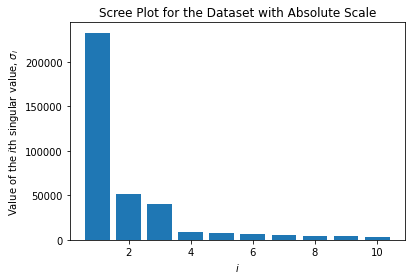

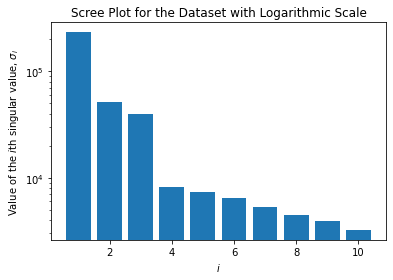

In [ ]:
### The following code computes the mean value for each variable, then subtracts it from each sample for that variable

# Set up the total value and mean vectors, and the centered data matrix
total_cross_validation = np.zeros(len(X_cross_validation[0]))
mean_cross_validation = np.zeros(len(X_cross_validation[0]))
X_cross_validation_centered = np.zeros((len(X_cross_validation), len(X_cross_validation[0])))

# Iterate through each of the values in each of the columns and sum their values to compute the total sum for each column,
for i in range(len(X_cross_validation)):
  for j in range(len(X_cross_validation[i])):
    total_cross_validation[j] = total_cross_validation[j] + X_cross_validation[i][j]

# Iterate through each of the columns, computing the mean by dividing the total for that column by the number of values
# Then subtract the mean from each value in that column
for m in range(len(X_cross_validation[0])):
  mean_cross_validation[m] = total_cross_validation[m] / (len(X_cross_validation) * len(X_cross_validation[0]))
  for n in range(len(X_cross_validation)):
    X_cross_validation_centered[n][m] = X_cross_validation[n][m] - mean_cross_validation[m]

# Compute the singular value decomposition of the centered data matrix
svd_X_cross_validation_centered = np.linalg.svd(X_cross_validation_centered)

x = []
num_singular_values = []

# compute the total energy in the dataset
total = 0
for i in range(len(svd_X_cross_validation_centered[1])):
  total += svd_X_cross_validation_centered[1][i] ** 2
  x.append(svd_X_cross_validation_centered[1][i])
  num_singular_values.append(i+1)

# Plot scree plot with absolute scale
plt.title('Scree Plot for the Dataset with Absolute Scale')
plt.xlabel('$i$')
plt.ylabel('Value of the $i$th singular value, $\sigma_i$')
plt.bar(num_singular_values[0:10], x[0:10])

# Plot scree plot with logarithmic scale
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.title('Scree Plot for the Dataset with Logarithmic Scale')
plt.xlabel('$i$')
plt.ylabel('Value of the $i$th singular value, $\sigma_i$')
plt.bar(num_singular_values[0:10], x[0:10])

# compute k such that the top-k principal components of the dataset capture at least 99% of the total energy
sum = 0
k = 0
while sum < 0.99 * total:
  sum += svd_X_cross_validation_centered[1][k] ** 2
  k = k + 1

print(str(k) + " Principal Components are Needed to Capture at least 99% of the Total Energy")

# Generate the PCA subspace using the singular value decomposition computed earlier
U_cross_validation = np.zeros((len(svd_X_cross_validation_centered[2]), k))

for i in range(len(svd_X_cross_validation_centered[2])):
  for j in range(k):
    U_cross_validation[i][j] = svd_X_cross_validation_centered[0][i][j]

### _2.1 (d)_

_The following code conducts 10-fold cross validation for our selected machine learning methods of LDA and k-nearest-neighbor. A total of 10 iterations are conducted, as we have set up our dataset for 10-fold cross validation. At each iteration, 1 of the 10 folds of the cross validation dataset is selected as the validation dataset for that iteration, while the other 9 folds become the training dataset._

_In each iteration, we first compute the mean vector for the training data and perform PCA on the centered training data. We then use the mean vector and PCA subspace computed for the training data to "center" the validation data and reduce its dimensionality. This gives us extracted features for both training and validation data._

_We then train the LDA model using the extracted features for the training data, and then test the LDA model on both training and validation data, determining the training and validation error of the LDA model for each iteration. Since we are running 10 iterations of cross-validation, we have 10 values each for training and validation error, so we report our performance as the average training error and average validation error across these 10 iterations. Since LDA does not involve any tuning parameters, we do not need to run multiple iterations of LDA for varying parameters at each iteration of 10-fold cross validation, and we simply report our average training error and average validation error as single scalars, rather than vectors in which each entry corresponds to the error at a different value of a tuning parameter. The fact that the average training error and average validation error are just scalars and that there are no parameters to be tuned also means that we don't need to graph the training and validation error; rather, we can just report their scalar values._

_Next, we test the k-nearest-neighbor model (k-nearest-neighbor does not involve any training). Notably, k-nearest-neighbor does use the tuning parameter $k$, so at each iteration, we must test the the k-nearest-neighbor model at varying values of $k$. Specifically, we select the values $k=1,...,10$ and test the the k-nearest-neighbor model for these values of $k$ on both training and validation data at each iteration. For both training data and validation data, we average the error across all iterations for each value of $k$, to give the average training error and average validation error at each value of $k$. We select the value of $k$ which minimizes the validation error for the machine learning system that goes into production, with some preference with lower values of $k$, as Occam's razor dictates that simpler solutions (corresponding to lower $k$ for k-nearest-neighbors) tend to be more effective._

_Notably, we found that the runtime of testing the k-nearest-neighbor model was unmanageably long, as for a single value of k, testing the model on training data required computing the distance between all possible combinations of the 4500 training data samples, for a total of $4500*4500=20250000$ comparisons, while testing the model on validation data required computing the distance between all possible combinations of the 500 validation data samples with the 4500 training data samples, for an additional $500*4500=2250000$ comparisons. This is further compounded by the fact that the k-nearest-neighbor model needs to be tested for 10 different values of $k$, for 10 iterations of 10-fold cross validation, so a total of $(20250000+2250000)*10*10 = 2250000000$ comparisons need to be made. To make the runtime of the k-nearest-neighbor model more manageable, we only compare each training and validation data sample to $\frac{1}{50}$ of the training data samples, selected at random. Thus, this isn't a true implementation of k-nearest-neighbors, and likely will achieve slightly worse performance than true k-nearest-neighbors, since it is assigning each sample to the label that is most common among the $k$ closest samples out of this sparse sampling of the dataset, rather than the label that is most common among the $k$ closest samples out of the entire dataset. However, this is an acceptable and common way of reducing the runtime of k-nearest-neighbor models. Source [1] of the bibliography informed us of the method and explains its details._

_We plot the average training error and average validation error for each $k$ to help visualize the data, assisting in making the decision of which value of $k$ to select. However, all plotting, analysis, and reporting of error is done in the next code block after this one, as this code block is simply concerned with performing 10-fold cross validation and collecting, but not visualizing, analyzing, or reporting the relevant data._

_During the process of training and testing the LDA model and testing the k-nearest-neighbor model, the time required for training and testing LDA was recorded for each iteration and the time required for testing k-nearest-neighbor was recorded for each iteration for each value of $k$. This data will allow us to compare the speed performance of LDA and k-nearest-neighbor in the next code block._

In [ ]:
# Set up scalars and matrices to hold error, execution time, and confusion matrix data
LDA_error_train = 0
LDA_error_validation = 0
K_NN_error_train = [[], [], [], [], [], [], [], [], [], []]
K_NN_error_validation = [[], [], [], [], [], [], [], [], [], []]

LDA_execution_time = 0
K_NN_execution_time = 0

LDA_confusion_matrix = np.zeros((10,4,4))
K_NN_confusion_matrix = np.zeros((10,10,4,4))

# Iterate through all 10 iterations of 10-fold cross validation
for a in range(10):
  # Set up validation and training datasets for the current iteration of 10-fold cross validation
  validation_index = 9-a
  X_validation = X_cross_validation[500*validation_index:500*(validation_index+1)]
  Y_validation = Y_cross_validation[500*validation_index:500*(validation_index+1)]
  X_train = np.vstack((X_cross_validation[0:500*validation_index], X_cross_validation[500*(validation_index+1):len(X_cross_validation)]))
  Y_train = np.vstack((Y_cross_validation[0:500*validation_index], Y_cross_validation[500*(validation_index+1):len(Y_cross_validation)]))

  ### The following code computes the mean value for each variable, then subtracts it from each sample for that variable

  LDA_start_time = time.time()

  # Set up the total value and mean vectors, and the centered data matrix
  total = np.zeros(len(X_train[0]))
  mean = np.zeros(len(X_train[0]))
  X_train_centered = np.zeros((len(X_train), len(X_train[0])))

  # Iterate through each of the values in each of the columns and sum their values to compute the total sum for each column
  for i in range(len(X_train)):
    for j in range(len(X_train[i])):
      total[j] = total[j] + X_train[i][j]

  # Iterate through each of the columns, computing the mean by dividing the total for that column by the number of values
  # Then subtract the mean from each value in that column
  for m in range(len(X_train[0])):
    mean[m] = total[m] / len(X_train)
    for n in range(len(X_train)):
      X_train_centered[n][m] = X_train[n][m] - mean[m]

  # Compute the singular value decomposition of the centered data matrix
  svd_X_train_centered = np.linalg.svd(X_train_centered)

  x = []

  # Generate the PCA subspace using the singular value decomposition
  U = np.zeros((len(X_train_centered[0]), k))

  for i in range(len(X_train_centered[0])):
    for j in range(k):
      U[i][j] = svd_X_train_centered[2][i][j]

  # Generate extracted features for training dataset
  X_f_train = np.zeros((np.shape(X_train)[0], k))

  for i in range(np.shape(X_train)[0]):
    X_f_train[i] = np.matmul(U.T,X_train[i])

  # Generate extracted features for validation dataset
  X_f_validation = np.zeros((np.shape(X_validation)[0], k))

  for i in range(np.shape(X_validation)[0]):
    X_f_validation[i] = np.matmul(U.T,X_validation[i])


  ### The following code trains the LDA classifier by computing the mean vectors, covariance matrix, and logs of prior probabilities

  # Set up arrays to hold the sums of data and means
  sum_cloudy_LDA = np.zeros(len(X_f_train[0]))
  sum_desert_LDA = np.zeros(len(X_f_train[0]))
  sum_green_area_LDA = np.zeros(len(X_f_train[0]))
  sum_water_LDA = np.zeros(len(X_f_train[0]))
  mu_cloudy_LDA = np.zeros(len(X_f_train[0]))
  mu_desert_LDA = np.zeros(len(X_f_train[0]))
  mu_green_area_LDA = np.zeros(len(X_f_train[0]))
  mu_water_LDA = np.zeros(len(X_f_train[0]))

  num_cloudy = 0
  num_desert = 0
  num_green_area = 0
  num_water = 0

  # Iterate through each sample in the training dataset, and for each sample, add each of its entries to the corresponding entry in the sum vectors
  for i in range(len(X_f_train)):
    for j in range(len(X_f_train[i])):
      if Y_train[i][0] == 1:
        sum_cloudy_LDA[j] += X_f_train[i][j]
        if j == 0:
          num_cloudy += 1
      elif Y_train[i][1] == 1:
        sum_desert_LDA[j] += X_f_train[i][j]
        if j == 0:
          num_desert += 1
      elif Y_train[i][2] == 1:
        sum_green_area_LDA[j] += X_f_train[i][j]
        if j == 0:
          num_green_area += 1
      else:
        sum_water_LDA[j] += X_f_train[i][j]
        if j == 0:
          num_water += 1

  # Divide each entry of the sum vectors by the number of samples to obtain the mean vectors for each class
  for j in range(len(X_f_train[0])):
    mu_cloudy_LDA[j] = sum_cloudy_LDA[j] / num_cloudy
    mu_desert_LDA[j] = sum_desert_LDA[j] / num_desert
    mu_green_area_LDA[j] = sum_green_area_LDA[j] / num_green_area
    mu_water_LDA[j] = sum_water_LDA[j] / num_water

  # Set up matrices for the covariance matrix
  sigma_LDA = np.zeros((len(X_f_train[0]),len(X_f_train[0])))
  sum_sigma_LDA = np.zeros((len(X_f_train[0]),len(X_f_train[0])))

  # Iterate through each sample in the training dataset, and for each sample, compute its addition to each entry of the sum covariance matrix
  for i in range(len(X_f_train)):
    for j in range(len(X_f_train[i])):
      for m in range(len(X_f_train[i])):
        if Y_train[i][0] == 1:
          sum_sigma_LDA[j][m] += (X_f_train[i][j] - mu_cloudy_LDA[j]) * (X_f_train[i][m] - mu_cloudy_LDA[m])
        elif Y_train[i][1] == 1:
          sum_sigma_LDA[j][m] += (X_f_train[i][j] - mu_desert_LDA[j]) * (X_f_train[i][m] - mu_desert_LDA[m])
        elif Y_train[i][2] == 1:
          sum_sigma_LDA[j][m] += (X_f_train[i][j] - mu_green_area_LDA[j]) * (X_f_train[i][m] - mu_green_area_LDA[m])
        else:
          sum_sigma_LDA[j][m] += (X_f_train[i][j] - mu_water_LDA[j]) * (X_f_train[i][m] - mu_cloudy_LDA[m])

  # Divide each entry of the sum covariance matrix by the number of samples to obtain the covariance matrix
  for j in range(len(X_f_train[0])):
    for m in range(len(X_f_train[0])):
      sigma_LDA[j][m] = sum_sigma_LDA[j][m] / len(X_f_train)

  # Compute the priors by taking the log of the fraction of samples belonging to each class
  prior_cloudy_LDA = np.log(num_cloudy / len(X_f_train))
  prior_desert_LDA = np.log(num_desert / len(X_f_train))
  prior_green_area_LDA = np.log(num_green_area / len(X_f_train))
  prior_water_LDA = np.log(num_water / len(X_f_train))


  # Compute LDA Results on Training and Validation Data

  # Initialize the Error Count to 0
  error_count_train_LDA = 0
  error_count_validation_LDA = 0

  # Set up the predicted label matrix for both training and validation data
  Y_train_hat_LDA = np.zeros((len(X_f_train),4))
  Y_validation_hat_LDA = np.zeros((len(X_f_validation),4))

  # For each test sample in the dataset, compute the label that the classifier assigns to it, and if it is incorrect, add 1 to the error count
  for i in range(len(X_f_train)):
    # Compute the value of the delta function for each class for each sample
    delta_cloudy_train_LDA = np.matmul(np.matmul(X_f_train[i].T,np.linalg.inv(sigma_LDA)),mu_cloudy_LDA) - 0.5 * np.matmul(np.matmul(mu_cloudy_LDA.T,np.linalg.inv(sigma_LDA)),mu_cloudy_LDA) + prior_cloudy_LDA
    delta_desert_train_LDA = np.matmul(np.matmul(X_f_train[i].T,np.linalg.inv(sigma_LDA)),mu_desert_LDA) - 0.5 * np.matmul(np.matmul(mu_desert_LDA.T,np.linalg.inv(sigma_LDA)),mu_desert_LDA) + prior_desert_LDA
    delta_green_area_train_LDA = np.matmul(np.matmul(X_f_train[i].T,np.linalg.inv(sigma_LDA)),mu_green_area_LDA) - 0.5 * np.matmul(np.matmul(mu_green_area_LDA.T,np.linalg.inv(sigma_LDA)),mu_green_area_LDA) + prior_green_area_LDA
    delta_water_train_LDA = np.matmul(np.matmul(X_f_train[i].T,np.linalg.inv(sigma_LDA)),mu_water_LDA) - 0.5 * np.matmul(np.matmul(mu_water_LDA.T,np.linalg.inv(sigma_LDA)),mu_water_LDA) + prior_water_LDA

    # Determine the predicted label based on the value of the delta functions 
    if(delta_cloudy_train_LDA > delta_desert_train_LDA and delta_cloudy_train_LDA > delta_green_area_train_LDA and delta_cloudy_train_LDA > delta_water_train_LDA):
      Y_train_hat_LDA[i][0] = 1
    elif(delta_desert_train_LDA > delta_cloudy_train_LDA and delta_desert_train_LDA > delta_green_area_train_LDA and delta_desert_train_LDA > delta_water_train_LDA):
      Y_train_hat_LDA[i][1] = 1
    elif(delta_green_area_train_LDA > delta_cloudy_train_LDA and delta_green_area_train_LDA > delta_desert_train_LDA and delta_green_area_train_LDA > delta_water_train_LDA):
      Y_train_hat_LDA[i][2] = 1
    else:
      Y_train_hat_LDA[i][3] = 1
    
    # Determine if there is an error - an error occurs when the predicted label does not exactly match the true label
    error_detected = False
    for j in range(4):
      if Y_train_hat_LDA[i][j] != Y_train[i][j]:
        error_detected = True
    
    # If an error is detected, increment the number of errors by 1
    if error_detected:
      error_count_train_LDA += 1

  # For each test sample in the dataset, compute the label that the classifier assigns to it, and if it is incorrect, add 1 to the error count
  for i in range(len(X_f_validation)):
    # Compute the value of the delta function for each class for each sample
    delta_cloudy_validation_LDA = np.matmul(np.matmul(X_f_validation[i].T,np.linalg.inv(sigma_LDA)),mu_cloudy_LDA) - 0.5 * np.matmul(np.matmul(mu_cloudy_LDA.T,np.linalg.inv(sigma_LDA)),mu_cloudy_LDA) + prior_cloudy_LDA
    delta_desert_validation_LDA = np.matmul(np.matmul(X_f_validation[i].T,np.linalg.inv(sigma_LDA)),mu_desert_LDA) - 0.5 * np.matmul(np.matmul(mu_desert_LDA.T,np.linalg.inv(sigma_LDA)),mu_desert_LDA) + prior_desert_LDA
    delta_green_area_validation_LDA = np.matmul(np.matmul(X_f_validation[i].T,np.linalg.inv(sigma_LDA)),mu_green_area_LDA) - 0.5 * np.matmul(np.matmul(mu_green_area_LDA.T,np.linalg.inv(sigma_LDA)),mu_green_area_LDA) + prior_green_area_LDA
    delta_water_validation_LDA = np.matmul(np.matmul(X_f_validation[i].T,np.linalg.inv(sigma_LDA)),mu_water_LDA) - 0.5 * np.matmul(np.matmul(mu_water_LDA.T,np.linalg.inv(sigma_LDA)),mu_water_LDA) + prior_water_LDA

    # Determine the predicted label based on the value of the delta functions
    if(delta_cloudy_validation_LDA > delta_desert_validation_LDA and delta_cloudy_validation_LDA > delta_green_area_validation_LDA and delta_cloudy_validation_LDA > delta_water_validation_LDA):
      Y_validation_hat_LDA[i][0] = 1
    elif(delta_desert_validation_LDA > delta_cloudy_validation_LDA and delta_desert_validation_LDA > delta_green_area_validation_LDA and delta_desert_validation_LDA > delta_water_validation_LDA):
      Y_validation_hat_LDA[i][1] = 1
    elif(delta_green_area_validation_LDA > delta_cloudy_validation_LDA and delta_green_area_validation_LDA > delta_desert_validation_LDA and delta_green_area_validation_LDA > delta_water_validation_LDA):
      Y_validation_hat_LDA[i][2] = 1
    else:
      Y_validation_hat_LDA[i][3] = 1
    
    # Determine if there is an error - an error occurs when the predicted label does not exactly match the true label
    error_detected = False
    for j in range(4):
      if Y_validation_hat_LDA[i][j] != Y_validation[i][j]:
        error_detected = True
    
    # If an error is detected, increment the number of errors by 1
    if error_detected:
      error_count_validation_LDA += 1
    
    # Generate the confusion matrix for LDA on validation data
    for m in range(4):
      for n in range(4):
        if Y_validation[i][m] == 1 and Y_validation_hat_LDA[i][n] == 1:
          LDA_confusion_matrix[a][m][n] += 1

  # Compute error probability for current iteration of LDA
  error_prob_train_LDA = error_count_train_LDA / len(X_f_train)
  error_prob_validation_LDA = error_count_validation_LDA / len(X_f_validation)

  # Update overall error probability for all iterations of LDA
  LDA_error_train += error_prob_train_LDA
  LDA_error_validation += error_prob_validation_LDA

  # Update execution time estimation for all iterations of LDA
  LDA_execution_time += time.time() - LDA_start_time


  # Compute K-NN Results on Training and Validation Data for k = 1,...,10

  # Define fraction of training points sampled as 1/sampling_factor
  sampling_factor = 50

  # Iterate through k = 1,...,10
  for k_nn in range(1,11):

    K_NN_start_time = time.time()

    # Initialize the Error Count to 0
    error_count_train_K_NN = 0

    # Set up predicted label matrix
    Y_train_hat_K_NN = np.zeros((len(X_f_train),4))

    # For each test sample in the dataset, compute the label that the classifier assigns to it, and if it is incorrect, add 1 to the error count
    for i in range(len(X_f_train)):

      # Setup the lists to hold the nodes and their distances to the current sample
      nodes = []
      distances = []

      # For 1/sampling_factor of the training samples in the dataset, compute its distance to the selected training data sample
      for j in range(int(len(X_f_train)/sampling_factor)):
        index = np.random.randint(len(X_f_train))
        distances.append(abs(X_f_train[i] - X_f_train[index]).sum())
        if Y_train[index][0] == 1:
          nodes.append(0)
        elif Y_train[index][1] == 1:
          nodes.append(1)
        elif Y_train[index][2] == 1:
          nodes.append(2)
        else:
          nodes.append(3)

      # Sort the list of nodes to find the k nearest neighbors
      nodes = [a for _, a in sorted(zip(distances, nodes))]
      
      # Compute the most common label among the k nearest neighbors for the training data sample
      num_cloudy = 0
      num_desert = 0
      num_green_area = 0
      num_water = 0
      for j in range(k_nn):
        if nodes[j] == 0:
          num_cloudy += 1
        elif nodes[j] == 1:
          num_desert += 1
        elif nodes[j] == 2:
          num_green_area += 1
        else:
          num_water += 1
      
      if(num_cloudy > num_desert and num_cloudy > num_green_area and num_cloudy > num_water):
        Y_train_hat_K_NN[i][0] = 1
      elif(num_desert > num_cloudy and num_desert > num_green_area and num_desert > num_water):
        Y_train_hat_K_NN[i][1] = 1
      elif(num_green_area > num_cloudy and num_green_area > num_desert and num_green_area > num_water):
        Y_train_hat_K_NN[i][2] = 1
      elif(num_water > num_cloudy and num_water > num_desert and num_water > num_green_area):
        Y_train_hat_K_NN[i][3] = 1
      elif(nodes[0]==0):
        Y_train_hat_K_NN[i][0] = 1
      elif(nodes[0]==1):
        Y_train_hat_K_NN[i][1] = 1
      elif(nodes[0]==2):
        Y_train_hat_K_NN[i][2] = 1
      else:
        Y_train_hat_K_NN[i][3] = 1
      
      # Determine if there is an error - an error occurs when the predicted label does not exactly match the true label
      error_detected = False
      for j in range(4):
        if Y_train_hat_K_NN[i][j] != Y_train[i][j]:
          error_detected = True
      
      # If an error is detected, increment the number of errors by 1
      if error_detected:
        error_count_train_K_NN += 1

    # Compute error probability for current iteration of K_NN on training data
    error_prob_train_K_NN = error_count_train_K_NN / len(X_f_train)

    # Update overall error probability for all iterations of K_NN on training data
    K_NN_error_train[k_nn-1].append(error_prob_train_K_NN)


    # Initialize the Error Count to 0
    error_count_validation_K_NN = 0

    # Set up predicted label matrix
    Y_validation_hat_K_NN = np.zeros((len(X_f_validation),4))

    # For each validation data sample in the dataset, compute the label that the classifier assigns to it, and if it is incorrect, add 1 to the error count
    for i in range(len(X_f_validation)):

      # Setup the lists to hold the nodes and their distances to the selected validation data sample
      nodes = []
      distances = []

      # For 1/sampling_factor of the training samples in the dataset, compute its distance to the selected validation data sample
      for j in range(int(len(X_f_train)/sampling_factor)):
        index = np.random.randint(len(X_f_train))
        distances.append(abs(X_f_validation[i] - X_f_train[index]).sum())
        if Y_train[index][0] == 1:
          nodes.append(0)
        elif Y_train[index][1] == 1:
          nodes.append(1)
        elif Y_train[index][2] == 1:
          nodes.append(2)
        else:
          nodes.append(3)

      # Sort the list of nodes to find the k nearest neighbors
      nodes = [a for _, a in sorted(zip(distances, nodes))]
      
      # Compute the most common label among the k nearest neighbors for the validation data sample
      num_cloudy = 0
      num_desert = 0
      num_green_area = 0
      num_water = 0
      for j in range(k_nn):
        if nodes[j] == 0:
          num_cloudy += 1
        elif nodes[j] == 1:
          num_desert += 1
        elif nodes[j] == 2:
          num_green_area += 1
        else:
          num_water += 1
      
      if(num_cloudy > num_desert and num_cloudy > num_green_area and num_cloudy > num_water):
        Y_validation_hat_K_NN[i][0] = 1
      elif(num_desert > num_cloudy and num_desert > num_green_area and num_desert > num_water):
        Y_validation_hat_K_NN[i][1] = 1
      elif(num_green_area > num_cloudy and num_green_area > num_desert and num_green_area > num_water):
        Y_validation_hat_K_NN[i][2] = 1
      elif(num_water > num_cloudy and num_water > num_desert and num_water > num_green_area):
        Y_validation_hat_K_NN[i][3] = 1
      elif(nodes[0]==0):
        Y_validation_hat_K_NN[i][0] = 1
      elif(nodes[0]==1):
        Y_validation_hat_K_NN[i][1] = 1
      elif(nodes[0]==2):
        Y_validation_hat_K_NN[i][2] = 1
      else:
        Y_validation_hat_K_NN[i][3] = 1
      
      # Determine if there is an error - an error occurs when the predicted label does not exactly match the true label
      error_detected = False
      for j in range(4):
        if Y_validation_hat_K_NN[i][j] != Y_validation[i][j]:
          error_detected = True
      
      # If an error is detected, increment the number of errors by 1
      if error_detected:
        error_count_validation_K_NN += 1

      # Generate the confusion matrix for LDA on validation data
      for m in range(4):
        for n in range(4):
          if Y_validation[i][m] == 1 and Y_validation_hat_K_NN[i][n] == 1:
            K_NN_confusion_matrix[a][k_nn-1][m][n] += 1

    # Update execution time estimation for all iterations of K_NN
    K_NN_execution_time += time.time() - K_NN_start_time

    # Compute error probability for current iteration of K_NN
    error_prob_validation_K_NN = error_count_validation_K_NN / len(X_f_validation)

    # Update overall error probability for all iterations of K_NN
    K_NN_error_validation[k_nn-1].append(error_prob_validation_K_NN)


# Compute average error probability for all iterations of LDA
LDA_average_error_train = LDA_error_train / 10
LDA_average_error_validation = LDA_error_validation / 10

# Compute average error probability for all iterations of K_NN, for all values of k=1,...,10
K_NN_average_error_train = np.zeros(10)
K_NN_average_error_validation = np.zeros(10)

for a in range(10):
  for i in range(len(K_NN_error_train[a])):
    K_NN_average_error_train[a] += K_NN_error_train[a][i]
    K_NN_average_error_validation[a] += K_NN_error_validation[a][i]
  K_NN_average_error_train[a] = K_NN_average_error_train[a] / 10
  K_NN_average_error_validation[a] = K_NN_average_error_validation[a] / 10

### _2.1 (e)_

_The following code performs the computations and plots the data needed for us to analyze the performance of LDA and k-nearest-neighbor in the 10-fold cross validation performed above. First, we report the average training and validation error for LDA. We observe that the average training error is approximately 0.2004, while the average validation error is approximately 0.2064. We should use the average validation error as our judgement of the performance of the LDA model at this point, since training data is seen by the LDA model during training, while validation data is unseen data. Thus, this is a good result because the average validation error is low. A random classifier would achieve an average validation error of roughly (but not exactly) 0.75, as each validation dataset consists of data belonging to 4 classes in approximately the equal amounts. Thus, as the LDA model has an average validation error of 0.2064, it is performing much closer to perfect (0 validation error) than random classification (roughly 0.75 valdiation error). Moreover, this is a promising result because the average validation error is only very slightly higher than the average training error, which indicates that the LDA model is not overfitting to the training data (if it were overfitting to the training data, the average validation error would be much higher than the average training error)._

_Next, we plot the average training and validation errors for each value of $k$ for k-nearest-neighbor. We observe that the average validation error is even lower for k-nearest-neighbor than it was for LDA, as the average validation error for k-nearest-neighbor is never more than about 0.165 for any value of $k$. The results seen here are not only promising because the average validation error is low, but also because we see that the average validation error is generally only slightly higher than the average training error, indicating that the k-nearest-neighbor model is not overfitting to the training data. We observe that the value of $k$ which minimizes the average validation error is $k=2$, which results in an average validation error of 0.1412. Therefore, we pick the value $k=2$ for the k-nearest-neighbor model that goes into production._

_We then report the average execution time for each iteration of LDA and each iteration of k-nearest-neighbor (for a single value of $k$), and observe that the average execution time for LDA is about 17.44 seconds, while the average execution time for k-nearest-neighbor is about 4.65 seconds, so k-nearest-neighbor is considerably faster._

_Finally, we compute and plot the confusion matrices for the performance of both LDA and k-nearest-neighbor on valdiation data. We observe that k-nearest-neighbor outperforms LDA, as both models perform very well in classifying cloudy and desert images correctly, but also have significant misclassifications in which a sample which actually belongs to the water class is classified as green area. However, these misclassifications are much less frequent for k-nearest-neighbor, so k-nearest-neighbor is outperforming LDA._

_Since we observe that k-nearest-neighbor for $k=2$ has an average validation error (0.1412) which is lower than that of LDA (0.2064), and has an average execution time (4.65 seconds) which is lower (faster) than that of LDA (17.44 seconds), and k-nearest-neighbor for $k=2$ displays better performance in its confusion matrices than LDA, k-nearest-neighbor is unambiguously outperforming LDA. Therefore, I would recommend that k-nearest-neighbor for $k=2$ is the model that goes into production._

_In the code block after this one, we will test the k-nearest-neighbor (for $k=2$) and LDA models on the test data, but cannot use the performance of these models to go back and tune the models again, as we may not tune our models to test data. Doing so would effectively make the test data no longer "unseen" to the models since knowledge of the test data would be used in developing the models. This would make any performance on test data no longer an accurate representation of how the models would perform on unseen data._

Average LDA Training Error = 0.20044444444444448
Average LDA Validation Error = 0.2064
The average validation error for k-nearest-neighbors is minimized by the value k = 2, which results in an average validation error of 0.1412
Average Training + Test Time for LDA is 17.4387934923172 seconds
Average Training + Test Time for k Nearest Neighbors is 4.652108745574951 seconds


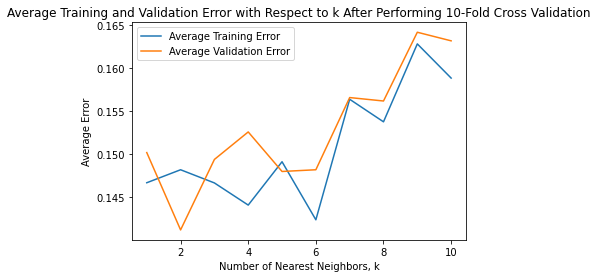

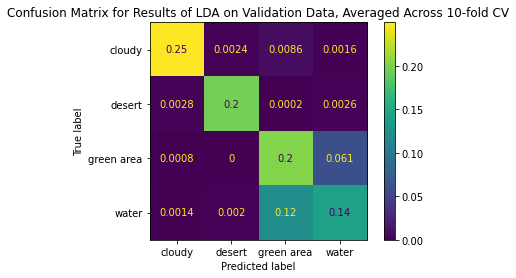

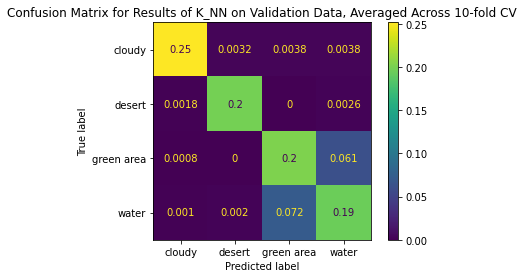

In [ ]:
print("Average LDA Training Error = " + str(LDA_average_error_train))
print("Average LDA Validation Error = " + str(LDA_average_error_validation))

# Compute the minimum validation error for k-nearest-neighbors and the value of k which produces this minimum validation error
k_minimization = 1
min_validation_error = K_NN_average_error_validation[0]

for i in range(len(K_NN_average_error_validation)):
  if K_NN_average_error_validation[i] < min_validation_error:
    min_validation_error = K_NN_average_error_validation[i]
    k_minimization = i+1

print("The average validation error for k-nearest-neighbors is minimized by the value k = " + str(k_minimization) + ", which results in an average validation error of " + str(min_validation_error))

# Plot average training and validation error for k-nearest-neighbor with respect to k
plt.plot([1,2,3,4,5,6,7,8,9,10], K_NN_average_error_train)
plt.plot([1,2,3,4,5,6,7,8,9,10], K_NN_average_error_validation)
plt.legend(['Average Training Error','Average Validation Error'])
plt.xlabel('Number of Nearest Neighbors, k')
plt.ylabel('Average Error')
plt.title('Average Training and Validation Error with Respect to k After Performing 10-Fold Cross Validation')

# Compute and report average execution time for LDA and k-nearest-neighbors
LDA_execution_time = LDA_execution_time / 10
K_NN_execution_time = K_NN_execution_time / 100

print("Average Training + Test Time for LDA is " + str(LDA_execution_time) + " seconds")
print("Average Training + Test Time for k Nearest Neighbors is " + str(K_NN_execution_time) + " seconds")

# Generate and normalize confusion matrices for LDA and k-nearest neighbors
LDA_confusion_matrix_normalized = np.zeros((4,4))
K_NN_confusion_matrix_normalized = np.zeros((4,4))

k_nn = 4

for m in range(4):
  for n in range(4):
    for a in range(10):
      LDA_confusion_matrix_normalized[m][n] += LDA_confusion_matrix[a][m][n]
      K_NN_confusion_matrix_normalized[m][n] += K_NN_confusion_matrix[a][k_nn-1][m][n]
    LDA_confusion_matrix_normalized[m][n] = LDA_confusion_matrix_normalized[m][n] / 5000
    K_NN_confusion_matrix_normalized[m][n] = K_NN_confusion_matrix_normalized[m][n] / 5000

# Display confusion matrices for LDA and k-nearest neighbors
LDA_CM = ConfusionMatrixDisplay(confusion_matrix = LDA_confusion_matrix_normalized, display_labels = ['cloudy', 'desert', 'green area', 'water'])

LDA_CM.plot()
plt.title('Confusion Matrix for Results of LDA on Validation Data, Averaged Across 10-fold CV')
plt.show()

K_NN_CM = ConfusionMatrixDisplay(confusion_matrix = K_NN_confusion_matrix_normalized, display_labels = ['cloudy', 'desert', 'green area', 'water'])

K_NN_CM.plot()
plt.title('Confusion Matrix for Results of K_NN on Validation Data, Averaged Across 10-fold CV')
plt.show()

_In the following code block, we test the trained LDA and k-nearest-neighbor models on test data. Having determined that the optimal value of $k$ is $k=2$ through 10-fold cross validation, we use the value $k=2$ for the k-nearest-neighbor model here._

_We use the mean vector and PCA subspace that we computed (before training) for the entire cross-validation dataset to "center" the test data and reduce its dimensionality. This gives us extracted features for both test data. This method follows our previous discussion that we should compute the mean vector for the entire cross-validation dataset and perform PCA on the centered cross-valdiation data to learn the corresponding PCA subspace, then use the mean vector learned for the cross-validation data to "center" the test data and perform dimensionality reduction on the test data using the PCA subspace learned for the cross-valdiation data. Thus, we have performed dimensionality reduction on test data using PCA without ever performing feature learning on test data._

_Similarly to in 10-fold cross validation, we only compare each test data sample to $\frac{1}{50}$ of the training data samples, selected at random, in order to make the runtime of the k-nearest-neighbor model more manageable._

_In the next code block after this one, we will report the test error for the LDA and k-nearest-neighbor models and display the corresponding confusion matrices._

In [ ]:
# Set up centered data matrix for test data
X_test_centered = np.zeros((len(X_test), len(X_test[0])))

# Iterate through each of the columns of the test data matrix, subtracting the mean previously computed for the cross validation data from each value in the corresponding column of the test data
for m in range(len(X_test)):
  for n in range(len(X_test[0])):
    X_test_centered[m][n] = X_test[m][n] - mean_cross_validation[n]

# Generate extracted features for test data using PCA subspace previously computed on cross validation data
X_f_test = np.zeros((np.shape(X_test)[0], k))

for i in range(np.shape(X_test)[0]):
  X_f_test[i] = np.matmul(U.T,X_test[i])

# Compute LDA Results on Test Data

# Set up confusion matrix for LDA on test data
LDA_confusion_matrix_test = np.zeros((4,4))

# Initialize the Error Count to 0
error_count_test_LDA = 0

# Set up predicted label matrix
Y_test_hat_LDA = np.zeros((len(X_f_test),4))

# For each test sample in the dataset, compute the label that the classifier assigns to it, and if it is incorrect, add 1 to the error count
for i in range(len(X_f_test)):
  # Compute the value of the delta function for each class for each sample
  delta_cloudy_test_LDA = np.matmul(np.matmul(X_f_test[i].T,np.linalg.inv(sigma_LDA)),mu_cloudy_LDA) - 0.5 * np.matmul(np.matmul(mu_cloudy_LDA.T,np.linalg.inv(sigma_LDA)),mu_cloudy_LDA) + prior_cloudy_LDA
  delta_desert_test_LDA = np.matmul(np.matmul(X_f_test[i].T,np.linalg.inv(sigma_LDA)),mu_desert_LDA) - 0.5 * np.matmul(np.matmul(mu_desert_LDA.T,np.linalg.inv(sigma_LDA)),mu_desert_LDA) + prior_desert_LDA
  delta_green_area_test_LDA = np.matmul(np.matmul(X_f_test[i].T,np.linalg.inv(sigma_LDA)),mu_green_area_LDA) - 0.5 * np.matmul(np.matmul(mu_green_area_LDA.T,np.linalg.inv(sigma_LDA)),mu_green_area_LDA) + prior_green_area_LDA
  delta_water_test_LDA = np.matmul(np.matmul(X_f_test[i].T,np.linalg.inv(sigma_LDA)),mu_water_LDA) - 0.5 * np.matmul(np.matmul(mu_water_LDA.T,np.linalg.inv(sigma_LDA)),mu_water_LDA) + prior_water_LDA

  # Determine the predicted label based on the value of the delta functions
  if(delta_cloudy_test_LDA > delta_desert_test_LDA and delta_cloudy_test_LDA > delta_green_area_test_LDA and delta_cloudy_test_LDA > delta_water_test_LDA):
    Y_test_hat_LDA[i][0] = 1
  elif(delta_desert_test_LDA > delta_cloudy_test_LDA and delta_desert_test_LDA > delta_green_area_test_LDA and delta_desert_test_LDA > delta_water_test_LDA):
    Y_test_hat_LDA[i][1] = 1
  elif(delta_green_area_test_LDA > delta_cloudy_test_LDA and delta_green_area_test_LDA > delta_desert_test_LDA and delta_green_area_test_LDA > delta_water_test_LDA):
    Y_test_hat_LDA[i][2] = 1
  else:
    Y_test_hat_LDA[i][3] = 1
    
  # Determine if there is an error - an error occurs when the predicted label does not exactly match the true label
  error_detected = False
  for j in range(4):
    if Y_test_hat_LDA[i][j] != Y_test[i][j]:
      error_detected = True
    
  # If an error is detected, increment the number of errors by 1
  if error_detected:
    error_count_test_LDA += 1
    
  # Compute the values in the confusion matrix for LDA on test data
  for m in range(4):
    for n in range(4):
      if Y_test[i][m] == 1 and Y_test_hat_LDA[i][n] == 1:
        LDA_confusion_matrix_test[m][n] += 1

# Compute the error probability for LDA on test data
error_prob_test_LDA = error_count_test_LDA / len(X_f_test)


# Set up confusion matrix for K_NN on test data
K_NN_confusion_matrix_test = np.zeros((4,4))

# Define fraction of training points sampled as 1/sampling_factor, using the same value of 50 as in training
sampling_factor = 50

# Define k=2 for k_nn, in accordance with observation that this value minimizes validation error
k_nn = 2

# Initialize the Error Count to 0
error_count_test_K_NN = 0

# Set up predicted label matrix
Y_test_hat_K_NN = np.zeros((len(X_f_test),4))

# For each test sample in the dataset, compute the label that the classifier assigns to it, and if it is incorrect, add 1 to the error count
for i in range(len(X_f_test)):

  # Setup the lists to hold the nodes and their distances to the selected test data sample
  nodes = []
  distances = []

  # For 1/sampling_factor of the training samples in the dataset, compute its distance to the selected test data sample
  for j in range(int(len(X_f_train)/sampling_factor)):
    index = np.random.randint(len(X_f_train))
    distances.append(abs(X_f_test[i] - X_f_train[index]).sum())
    if Y_train[index][0] == 1:
      nodes.append(0)
    elif Y_train[index][1] == 1:
      nodes.append(1)
    elif Y_train[index][2] == 1:
      nodes.append(2)
    else:
      nodes.append(3)

  # Sort the list of nodes to find the 4 nearest neighbors
  nodes = [a for _, a in sorted(zip(distances, nodes))]
      
  # Compute the most common label among the 4 nearest neighbors for the selected test data sample
  num_cloudy = 0
  num_desert = 0
  num_green_area = 0
  num_water = 0
  for j in range(k_nn):
    if nodes[j] == 0:
      num_cloudy += 1
    elif nodes[j] == 1:
      num_desert += 1
    elif nodes[j] == 2:
      num_green_area += 1
    else:
      num_water += 1
      
  if(num_cloudy > num_desert and num_cloudy > num_green_area and num_cloudy > num_water):
    Y_test_hat_K_NN[i][0] = 1
  elif(num_desert > num_cloudy and num_desert > num_green_area and num_desert > num_water):
    Y_test_hat_K_NN[i][1] = 1
  elif(num_green_area > num_cloudy and num_green_area > num_desert and num_green_area > num_water):
    Y_test_hat_K_NN[i][2] = 1
  elif(num_water > num_cloudy and num_water > num_desert and num_water > num_green_area):
    Y_test_hat_K_NN[i][3] = 1
  elif(nodes[0]==0):
    Y_test_hat_K_NN[i][0] = 1
  elif(nodes[0]==1):
    Y_test_hat_K_NN[i][1] = 1
  elif(nodes[0]==2):
    Y_test_hat_K_NN[i][2] = 1
  else:
    Y_test_hat_K_NN[i][3] = 1
      
  # Determine if there is an error - an error occurs when the predicted label does not exactly match the true label
  error_detected = False
  for j in range(4):
    if Y_test_hat_K_NN[i][j] != Y_test[i][j]:
      error_detected = True
      
  # If an error is detected, increment the number of errors by 1
  if error_detected:
    error_count_test_K_NN += 1

  # Compute the values in the confusion matrix for K_NN on test data
  for m in range(4):
    for n in range(4):
      if Y_test[i][m] == 1 and Y_test_hat_K_NN[i][n] == 1:
        K_NN_confusion_matrix_test[m][n] += 1

# Compute the error probability for LDA on test data
error_prob_test_K_NN = error_count_test_K_NN / len(X_f_test)

_The following code performs the computations and plots the data needed for us to view the performance of the LDA and k-nearest-neighbor models on test data. First, we report the test error for LDA, which is 0.1791. This is a good result because the test error for LDA is low. A random classifier would achieve a test error of roughly (but not exactly) 0.75, as the test dataset consists of data belonging to 4 classes in approximately the equal amounts. Thus, since the LDA model has a test error of 0.1791, it is performing much closer to perfect (0 test error) than random classification (roughly 0.75 test error). Interestingly, the test error for LDA is actually slightly lower than the average validation error from 10-fold cross validation for LDA (0.2064), and the average training error from 10-fold cross validation for LDA (0.2004). The fact that the test error is lower than the average validation error from 10-fold cross validation for LDA is not a major surprise, as LDA involves no tuning parameters, and therefore the LDA model was not in any way tuned to the validation datasets. Thus, the validation datasets were essentially like test data, and it concidentally happened that the actual test dataset happened to result in less error than was seen on average in the validation datasets. What is a more interesting result is that the test error (0.1791) is lower than the training error (0.2004) for LDA. This was likely just coincidence and a result of the limited sample size of the dataset. This result is also promising, as it indicates that the LDA model is not overfitting to the training data (if it were overfitting to the training data, the test error would be much higher than the average training error)._

_We then report the test error for k-nearest-neighbor, which is 0.1157. This is a good result because the test error for k-nearest-neighbor is also low, as it is performing much closer to perfect (0 test error) than random classification (roughly 0.75 test error). Again, we see a curious result in that the test error for k-nearest-neighbor for $k=2$ (0.1157) is actually slightly lower than the validation error for k-nearest-neighbor for $k=2$ (0.1412). This was again likely just coincidence and a result of the limited sample size of the dataset. This result is also promising, as it indicates that the k-nearest-neighbor model (for $k=2$) is not overfitting to the validation data (if it were overfitting to the validation data, the test error would be much higher than the average validation error)._

_Finally, we compute and plot the confusion matrices for the performance of both LDA and k-nearest-neighbor on test data. We observe that k-nearest-neighbor outperforms LDA, as it did on validation data, as both models perform very well in classifying cloudy and desert images correctly, but also have significant misclassifications in which a sample which actually belongs to the water class is classified as green area. However, these misclassifications are much less frequent for k-nearest-neighbor, so k-nearest-neighbor is outperforming LDA._

_By testing the LDA and k-nearest-neighbor models on test data, we confirm that they perform well on unseen data, and thus are useful machine learning systems which have genuinely learned the patterns in the data, rather than overfitting to training data. We also show that on unseen data, k-nearest-neighbor for $k=2$ continues to outperform LDA, as its test error of 0.1157 is lower than that of LDA (0.1791), and it displays better performance in the confusion matrices. As previously mentioned, we cannot now go back and use the performance of these models to tune the models again, as we may not tune our models to test data. Doing so would effectively make the test data no longer "unseen" to the models since knowledge of the test data would be used in developing the models. This would make any performance on test data no longer an accurate representation of how the models would perform on unseen data._

LDA Test Error = 0.179080824088748
k-Nearest-Neighbor Test Error = 0.11568938193343899


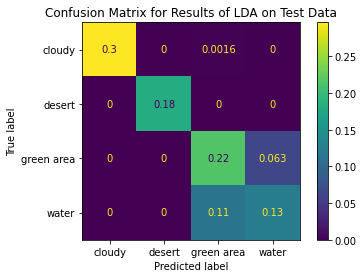

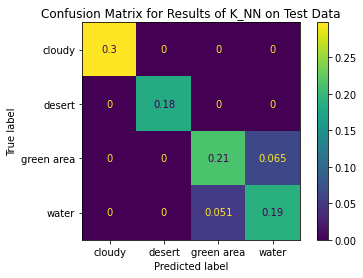

In [ ]:
print("LDA Test Error = " + str(error_prob_test_LDA))
print("k-Nearest-Neighbor Test Error = " + str(error_prob_test_K_NN))

# Generate and normalize confusion matrices for LDA and k-nearest neighbors
LDA_confusion_matrix_test_normalized = np.zeros((4,4))
K_NN_confusion_matrix_test_normalized = np.zeros((4,4))

k_nn = 5

for m in range(4):
  for n in range(4):
    LDA_confusion_matrix_test_normalized[m][n] = LDA_confusion_matrix_test[m][n] / 631
    K_NN_confusion_matrix_test_normalized[m][n] = K_NN_confusion_matrix_test[m][n] / 631

# Display confusion matrices for LDA and k-nearest neighbors
LDA_CM_test = ConfusionMatrixDisplay(confusion_matrix = LDA_confusion_matrix_test_normalized, display_labels = ['cloudy', 'desert', 'green area', 'water'])

LDA_CM_test.plot()
plt.title('Confusion Matrix for Results of LDA on Test Data')
plt.show()

K_NN_CM_test = ConfusionMatrixDisplay(confusion_matrix = K_NN_confusion_matrix_test_normalized, display_labels = ['cloudy', 'desert', 'green area', 'water'])

K_NN_CM_test.plot()
plt.title('Confusion Matrix for Results of K_NN on Test Data')
plt.show()

### _2.1 (f)_

_Some ethical concerns arise due to the nature of our training dataset and because of the slightly unusual result we have encountered in which test error was lower than training error for LDA and test error was lower than validation error for k-nearest-neighbor._

_Because our machine learning system performs a task (satellite image classification) which does not directly involve or affect human beings, and likely won't be used to make any critical decisions, there aren't as strong of ethical concerns with this machine learning system as there might be with some others. However, some ethical concerns still do arise. For example, depending on how zoomed in some satellite images may be, they may display people, private property, or government land which is intended to be kept secret. People, property owners, and governments should have a right to privacy, and therefore the images of themselves, their property, and their land should be removed from the dataset._

_Another ethical concern which arises from this machine learning system pertains to the means by which its performance is reported. While in general, performance on unseen (test) data is the correct and reliable way to test machine learning systems, we must take note of the fact that for LDA, the average training error from 10-fold cross validation (0.2004) was higher than the test error (0.1791). Also, for k-nearest-neighbor for $k=2$, the average validation error from 10-fold cross validation (0.1412) was higher than the test error (0.1157). As a result, the test error of 0.1791 for LDA and test error of 0.1157 for k-nearest-neighbor are likely coincidental and the result of limited sample size, and probably are not sustainable for large sample sizes. Therefore, reporting the performance of the LDA model on test data as achieving an error rate of 0.1791 and reporting the performance of the k-nearest-neighbor model on test data as achieving an error rate of 0.1157 without any further context is misleading. In order to ethically and accurately report the performance of the LDA model, the 0.1791 test error figure may be reported, but only when coupled with an acknowledgement that the average training error of 0.2004 suggests that the performance on test data is unsustainable over very large sample sizes. Similarly, to ethically and accurately report the performance of the k-nearest-neighbor model, the 0.1157 test error figure may also be reported, but only when coupled with an acknowledgement that the average validation error of 0.1412 suggests that the performance on test data is unsustainable over very large sample sizes._

### _2.1 (g)_

_Bibliography:_

_This machine learning task was done overwhelmingly using our knowledge of machine learning acquired in this class. Reference tools used to assist in this task primarily consisted of our own and the Professor's lecture notes, expecially those from Class 6 (for Principal Component Analysis), Class 16 (for LDA), Class 17 (for k-nearest-neighbor), Class 18 (for confusion matrices), and Class 19 (for cross validation). The following source was the only one used for this machine learning task which did not come from the course materials. It informed us of how to randomly sample training points for measurement for the k-nearest-neighbor model, rather than to use all training points for measurement._

_1: Malato, G. (2019, March 28). How to Correctly Select a Sample From a Huge Dataset in Machine Learning. Medium. Retrieved December 17, 2022, from https://medium.com/data-science-reporter/how-to-correctly-select-a-sample-from-a-huge-dataset-in-machine-learning-24327650372c_